## Statistical Methods for the Physical Sciences (5214SMFA3Y)
## Individual mini-Project -- Model fitting and hypothesis testing: the search for WIMPs
### Timo Halbesma, 6126561, 2016/01/08

In [1]:
# Enable showing plots inside iPython notebook
%matplotlib inline

In [2]:
import scipy
from scipy import stats
import numpy
import matplotlib
from matplotlib import pyplot
import pandas

matplotlib.rcParams.update({'font.size': 22})

### Introduction
Current data from the Fermi gamma-ray observatory is providing hints of the existence of anomalous extended GeV gamma-ray emission at the centre of our galaxy. This GeV continuum emission is causing excitement in the astroparticle-physics community, because it may be associated with the decay of the hitherto-undetected weakly interacting massive particles (WIMPs), which are thought to make up dark matter.

This mini-project is based on analysing simulated spectral data from a hypothetical future gamma-ray observatory, whose main objective is to search for and study the extended dark matter decay signature in the centres of nearby galaxies. The data consists of a list of energies of photons detected in an observation of a nearby galaxy. Your task is to convert this data into a gamma-ray spectrum (this is just a histogram of photon numbers versus energy in discrete energy bins), carry out some simple tests and determine the shape of the continuum (with errors on the model parameters) as well as search for and characterise spectral emission lines.


### Objectives
_Important note_: throughout all of the following you should assume that in addition to any astrophysical source photons with spectra described below, there is an additional instrumental background photon continuum which contributes a constant number of photons per GeV. For the dataset you are given, $C = 1.5$ photons/GeV.

### Question 1
- The simple alternative to dark matter decay is that the continuum is produced by the combined unresolved emission from a large number of gamma-ray pulsars in the centre of the target galaxy. Assume that the spectrum of gamma-ray pulsars is a simple power- law following the relation: $$ dN = N_0 \left( \frac{E}{E_0} \right)^{-\Gamma} dE $$ where in our formalism, $dN$ is the number of photons expected in the infinitesimal energy range $dE$, and $N_0$ is the normalisation of the spectrum (in photons/GeV) at a fixed photon energy $E_0$. $\Gamma$ is the power-law index and is also known as the 'photon index'. Assuming that $\Gamma = 2$, use a _non-parametric significance test_ to compare the shape of this pulsar spectrum with that of your data (note that you don't need to know $N_0$!).

### Answer 1

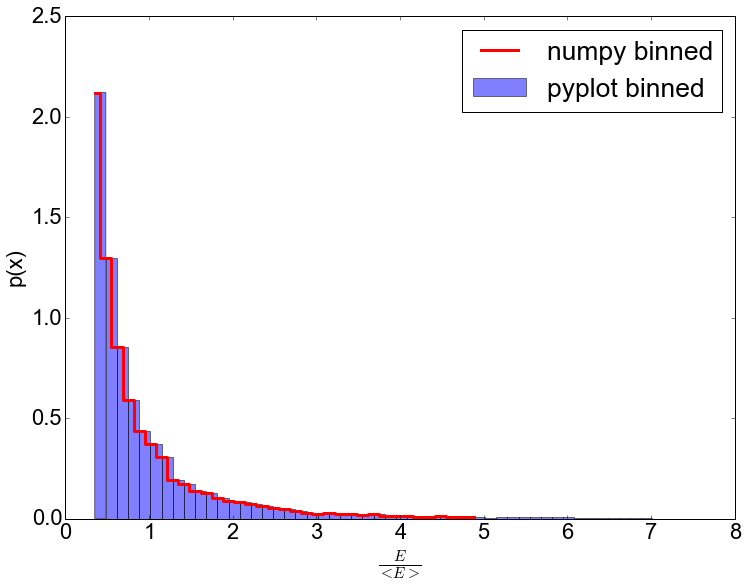

The (Scipy built-in) K-S test gives us a D-value of 0.25714 corresponding to a p-value of 0.16756.
This means that with 0.83244 certainty we can say that the two samples are drawn from a different distribution.


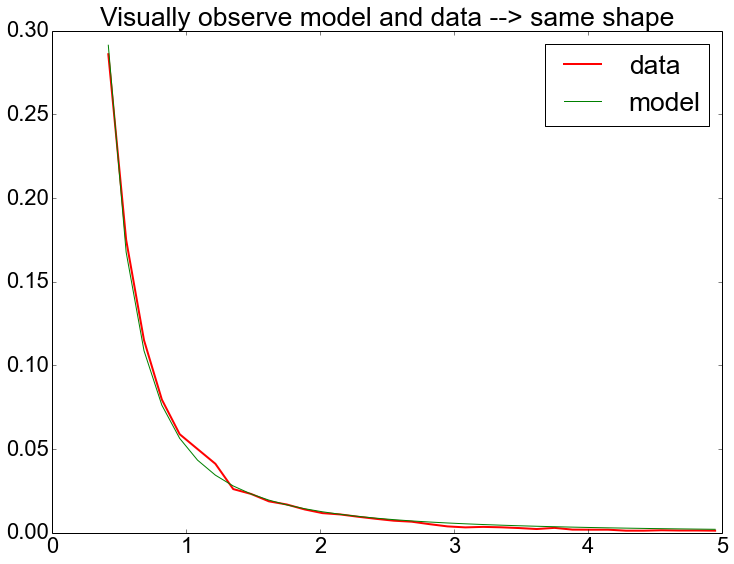

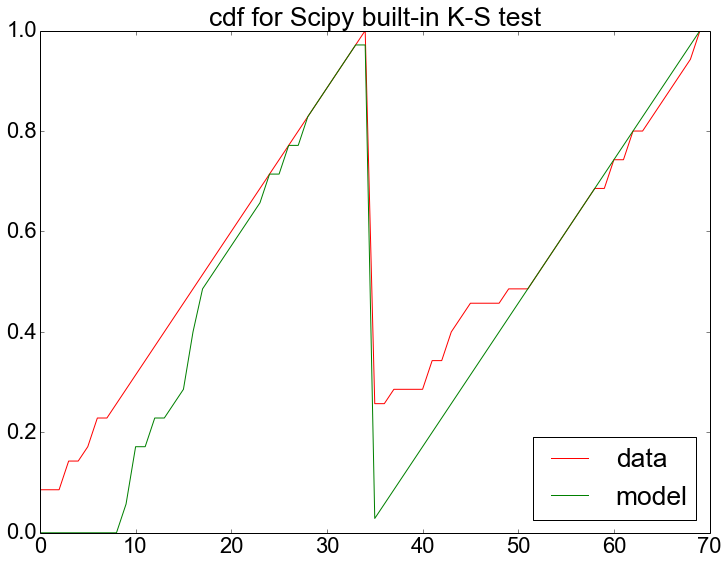

The (Scipy copied) K-S test gives us a D-value of 0.25714


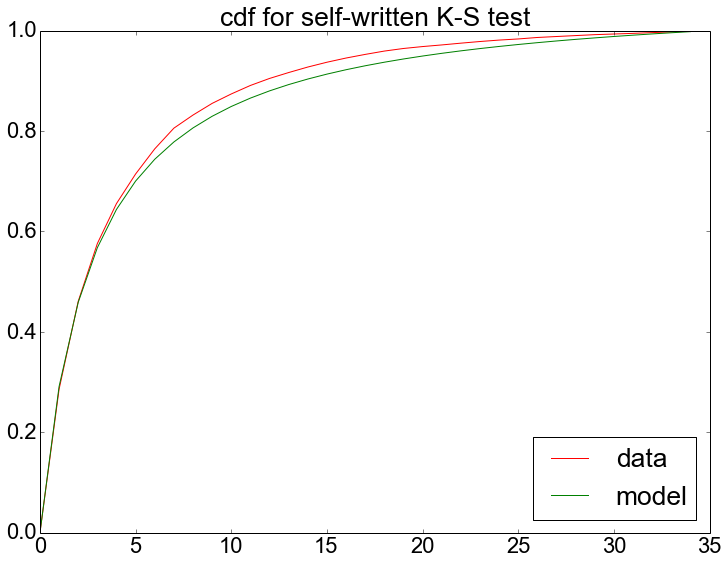

The (self-written) K-S test gives us a D-value of 0.02750

Spearman's Rho = 0.992854228109, p-value = 4.73681199152e-32
t = 47.7947417279


In [3]:
def parse_and_clean_dataset(filename="Halbesma_energies.txt"):
    ''' read data from file
        clean is not needed; file only contains one column with .2f '''
    energies = numpy.genfromtxt(filename, skiprows=0)
    
    return energies


def create_and_plot_histogram(energies, plot=True):
    ''' create and plot a histogram of the data '''
    
    # Divide data by mean value
    energies = energies / (numpy.mean(energies))
    
    # Bin up the data
    sample_size = len(energies)
    nr_of_bins = 50 # int(10*numpy.log(sample_size))
    counts, edges = numpy.histogram(energies,
        range=[numpy.min(energies), numpy.max(energies)],
        bins=nr_of_bins, density=False)
    
    # Correct for background counts: C = 1.5 photons/GeV
    binsize = edges[1] - edges[0]  # in GeV
    counts = counts - (1.5 * binsize)
    
    # Cut the bins with less than 20 counts --> Poisson
    counts = counts[counts > 20]
    edges = edges[0:len(counts) + 1]  # +1 because len(edges) = len(counts) +1
  
    # Normalise. Don't let numpy.histogram do this because that would mess up the error calculation!
    dens = counts / (sample_size * binsize)
    
    # Calculate intrinsic error of bin (normalised)    
    # We assume that the binning process follows a Poisson distribution --> err = sqrt(N)
    err = numpy.sqrt(counts) / (sample_size * binsize)

    if plot:
        # Plot histogram. Compare pyplot binning with numpy.hist binning.
        f, (ax1) = pyplot.subplots(1, 1, figsize=(12, 9))
        # NB not corrected for background photons, bins not cut when counts < 20!
        # So this can be used as a sanity check because it is only the binned data!
        ax1.hist(energies, bins=nr_of_bins, facecolor='b',
                 label="pyplot binned", alpha=0.5, normed=True)
        ax1.plot(edges[:-1], dens, lw=3, c="r",
                 ls="steps-mid", label="numpy binned")
        ax1.set_ylabel("p(x)")
        ax1.set_xlabel(r'$\frac{E}{<E>}$')

        ax1.legend(loc=1)
        pyplot.show()
    
    # We are interested in the binned arrays for further analysis.
    return dens, edges, err


def non_parametric_significance_test(energies, plot=True):
    ''' Assume spectum of gamma-ray pulsars is simple power low (not dark matter decay)
        dN = N_0 (E/E_0)**(-Gamma) dE
            
    Assume Gamma = 2, then perform non-parametric significance test to compare shape
        of pulsar spectrum with that of the data
    '''

    dens, edges, err = create_and_plot_histogram(energies)
    
    # Perform Kolmogorov-Smirnov Test.
    binsize = edges[1] - edges[0]
    bin_center = edges + (binsize)/2.
    bin_center = bin_center[:-1]

    dN = bin_center**-2 * binsize
    
    dens = dens/numpy.sum(dens)
    dN = dN/numpy.sum(dN)
    
    (D_value, p_value) = scipy.stats.ks_2samp(dens, dN)
    
    print "The (Scipy built-in) K-S test gives us a D-value of {0:.5f}".format(D_value),
    print "corresponding to a p-value of {0:.5f}.".format(p_value)
    
    certain = 1.0 - p_value

    print "This means that with {0:.5f} certainty we can say".format(certain),
    print "that the two samples are drawn from a different distribution."
    
    if plot:
        f, (ax1) = pyplot.subplots(1, 1, figsize=(12, 9))
        ax1.plot(bin_center, dens,
                 c="r", lw=2, label="data")
        ax1.plot(bin_center, dN, label="model")

        ax1.legend(loc=1)
        pyplot.title("Visually observe model and data --> same shape")
        pyplot.show()
    
    
    show_Scipy_KS_routine = True
    if show_Scipy_KS_routine:
        # Show what Scipy built-in K-S test computes
        data1 = numpy.sort(dens)
        data2 = numpy.sort(dN)
        n1 = data1.shape[0]
        n2 = data2.shape[0]
        data_all = numpy.concatenate([data1, data2])
        cdf1 = numpy.searchsorted(data1, data_all, side='right') / (1.0*n1)
        cdf2 = numpy.searchsorted(data2, data_all, side='right') / (1.0*n2)
        pyplot.figure(figsize=(12, 9))
        pyplot.title("cdf for Scipy built-in K-S test")
        pyplot.plot(cdf1, c="r", label="data")
        pyplot.plot(cdf2, label="model")
        pyplot.legend(loc=4)
        pyplot.show()
        d = numpy.max(numpy.absolute(cdf1 - cdf2))
        print "The (Scipy copied) K-S test gives us a D-value of {0:.5f}".format(d)
    
    # NB we cannot use the binned data in the Scipy ks_2samp function, so we write our own implementation
    
    # NB dens.sum() != 1, but numpy.sum(dens*numpy.diff(edges)) is 1! See documentation.
    # For this reason (to obtain a normalised cdf) we divide the sum out.
    dens = dens/numpy.sum(dens)
    dN = dN/numpy.sum(dN)
    
    # Calculate cdf
    dens_cdf = numpy.zeros(len(dens))
    dN_cdf = numpy.zeros(len(dens))
    for i in xrange(1, len(dens)):
        dens_cdf[i] = dens_cdf[i-1] + dens[i-1]
        dN_cdf[i] = dN_cdf[i-1] + dN[i-1]
    
    # Sanity check of cdf: does it go from 0 to 1, is behaviour of data and model as expected?
    if plot:
        pyplot.figure(figsize=(12, 9))
        pyplot.title("cdf for self-written K-S test")
        pyplot.plot(dens_cdf, c="r", label="data")
        pyplot.plot(dN_cdf, label="model")
        pyplot.legend(loc=4)
        pyplot.show()
    
    # Obtain differences between both cdf's, sum
    D_value = numpy.max(dens_cdf - dN_cdf)
    
    # How to calculate p-value from D-value?
    print "The (self-written) K-S test gives us a D-value of {0:.5f}".format(D_value)#,
    # print "corresponding to a p-value of {0:.5f}.".format(p_value)
    
    # certain = 1.0 - p_value

    # print "This means that with {0:.5f} certainty we can say".format(certain),
    # print "that the two samples are drawn from a different distribution."
    print
    
    # Calculate Spearman's rho correlation co-efficient
    n = len(dens)
    rho, pval = scipy.stats.spearmanr(dens, dN)
    t = rho * numpy.sqrt((n - 2) / (1 - rho**2))
    print "Spearman's Rho = {0}, p-value = {1}\nt = {2}".format(rho, pval, t)
    

if __name__ == '__main__':
    energies = parse_and_clean_dataset()
    non_parametric_significance_test(energies)


** Binning the data **

Since Riley was kind enough to provide solutions for the previous assignment, and this assignment is similar to the last question of the previous assignment: why not steal Riley's code? I mean, it's the teacher's code so it must be correct and this must be the way to go, right?

In the words of Riley: 
> Let's first load in the data, normalise the ~~count rate~~ **energy** values by the mean ~~count rate~~ **energy** (anticipating that it will be easier to optimize our fit with smaller x values), bin the ~~count rate~~ **energy** values into evenly-sized bins, and discard the bins in the tails of the distribution if they have < 20 counts. We can then calculate the error on the probability density of each bin based on the assumption that we can approximate the binning process as following a Poisson distribution (it actually follows a binomial distribution, since we are dealing with the probability that a given x-value is binned into the bin of interest). Then we can set error = $\sqrt{n}$, where $n$ is the number of values in the bin. This makes sense if you just notice that the variance of a Poisson distribution is the expected ~~count rate~~ **energy**. We then make a quick plot of the distribution, shown below.

So, now you know how I binned my data :-). Mind you, the blue histogram is generated from the raw data. Here matplotlib bins the data, and it is not corrected for background photons and bins with counts < 20 are not ignored. So this can be used as a sanity check because it is only the binned data, nothing else happend. Indeed, we can see that the tail has fallen out of the self-binned data. Since the background is relatively low (only 1.5 photon/GeV) one does not visually observe that difference.

** Performing non-parametric significance tests **

There are two non-parametric significance tests we would like to perform, the K-S test and Spearman's $\rho$.

The Kolmogorov-Smirnov is implemented in Scipy. From the documentation:
> This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.

> If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

Here we have a very low $p$-value, which would mean that we have to reject $H_0$ that the samples are drawn from the same distribution, so this would imply that the assumed model is very poor to describe the data. However, I have also provided a plot because if one were to visually inspect the data and the model, then we would expect the statistical test to suggest that the distributions may be the same.

Naturally, I had to trace what the Scipy built-in function does (because treating it like a black box is very prone to errors). Indeed we observe some rather strange behaviour in the cdf generated by Scipy's built-in K-S method. On the other hand, our self-defined cdf behaves quite well. From this we can compute the $D$-value, but it is not straightforward to transform this to a $p$-value.

The next non-parametric significance test we can perform is Spearman's Rho test. From the documentation:
>Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact monotonic relationship

> The two-sided p-value for a hypothesis test whose null hypothesis is that two sets of data are uncorrelated, has same dimension as rho.

Here we see a high value $\rho$ in the order of unity. This means that both samples are correlated. The corresponding $p$-value given is the $p$-value for the null hypothesis $H_0$ that if the two sets of data are uncorrelated the obtained $\rho$ would have the same dimensions as found. This implies that the data are correlated, and the shape of the spectrum should be good to describe the data. Both tests do seem to contradict oneanother though.

### Final answer for question 1

We have tried to perform a KS test and we computed Spearman's $\rho$. The Scipy-built in K-S test suggests that the null hypothesis that the data are drawn from the same dristribution would be rejected. On the other hand, if we eyeball the shape of the binned spectrum and the given power law we do see similiarities, which are confirmed by Spearman's $\rho$ value in the order of unity. The corresponding $p$-value suggests that the null hypothesis that the data are uncorrelated could be rejected.

The combination of eyeballing the shape of the binned spectra and the shape of the power-law, the similarities between the self-written cdfs and the value found for Spearman's $\rho$ leads me to believe that the data are probably correlated and are likely drawn from the same distribution. The next assignment (fitting) could perhaps yield some sensible results.

### Question 2
- Fit the observed spectrum with continuum models and find the best-fitting model. You should compare the following three possibilities:
    - A simple power-law.
    - A broken power-law:
    $$ dN = N_0 \left( \frac{E}{E_0} \right)^{-\Gamma_1} dE \quad \rm{ for } E \leq E_{\rm bk} $$ $$ dN = N_0 \left( \frac{E_{\rm bk}}{E_0} \right)^{-\Gamma_1} \left( \frac{E}{E_{\rm bk}} \right)^{-\Gamma_2} dE \quad \rm{ for } E > E_{\rm bk} $$ where $E_{\rm bk}$ is the break energy and $\Gamma_1$ and $\Gamma_2$ denote respectively the photon indices below and above the break energy.
    - An exponentially cut-off power-law:
    $$ dN = N_0 \left( \frac{E}{E_0}\right)^{- \Gamma} \exp\left(-E/E_{\rm cut}\right) dE $$ where $E_{\rm cut}$ is the cut-off energy.

### Answer 2

[MLEs], chisq/dof: [ 1.1355441   1.43241065  1.95256653] 11.8098580026
The p-value for the simple distribution is: 0.00000
[MLEs], chisq/dof: [ 1.24204176  1.21116217  2.01119276  1.9525617   0.02091707] 12.5971818158
The p-value for the broken distribution is: 0.00000
[MLEs], chisq/dof: [ 1.33314775  2.16723852  1.45398134  2.34687333] 1.76126492426
The p-value for the exp_cut distribution is: 0.00553


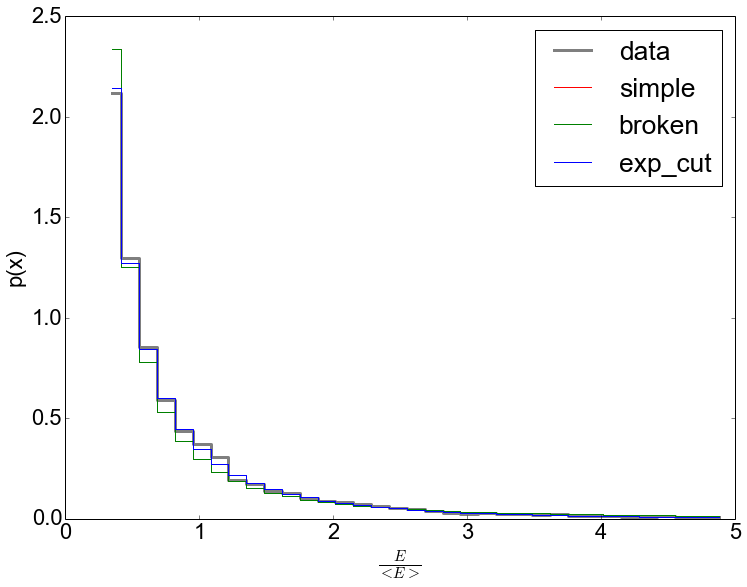

In [4]:
# Define our three models
def simple_power_law(parm, x, dE):
    N_0 = parm[0]
    E_0 = parm[1]
    Gamma = parm[2]
    E = x
    
    dN = N_0 * (E/E_0)**(-1. * Gamma) * dE
    return dN


def broken_power_law(parm, x, dE):
    N_0 = parm[0]
    E_0 = parm[1]
    Gamma_1 = parm[2]
    Gamma_2 = parm[3]
    E_bk = parm[4]  # Is this a fit parameter, though?
    
    E_below = x[x <= E_bk]
    E_above = x[x > E_bk]              
    
    dN_below = N_0 * (E_below/E_0)**(-1. * Gamma_1) * dE  
    dN_above = N_0 * (E_bk/E_0)**(-1. * Gamma_1) * (E_above/E_bk)**(-1. * Gamma_2) * dE
        
    dN = numpy.concatenate([dN_below, dN_above])
    # dN = pandas.concat([dN_below, dN_above])
    return dN


def exponentially_cut_off_power_law(parm, x, dE):
    N_0 = parm[0]
    E_0 = parm[1]
    Gamma = parm[2]
    E_cut = parm[3]  # Is this a fit parameter, though?
    E = x
    
    dN = N_0 * (E/E_0)**(-1. * Gamma) * numpy.exp(-1. * E/E_cut) * dE
    return dN


# Define the statistical model, in this case we shall use a chi-squared distribution, assuming normality in the errors
def stat(parm, x, y, dy, dist, dE):
    if dist == "simple":
        ymod = simple_power_law(parm, x, dE)
    elif dist == "broken":
        ymod = broken_power_law(parm, x, dE)
    elif dist == "exp_cut":
        ymod = exponentially_cut_off_power_law(parm, x, dE)
    else:
        print "This function is not defined....choose another"
        return None
    
    X = sum((y - ymod)**2 / dy**2)
    return(X)


def fit_observed_spectrum_with_continuum_models(energies):
        dens, edges, err = create_and_plot_histogram(energies, plot=False)
        x = edges[:-1]
        
        binsize = edges[1] - edges[0]  # in GeV
        
        # define an array of different dist names
        dists = ["simple", "broken", "exp_cut"]
        cols = ["red", "green", "blue"]
        results = {}
        # moddof = 3.
        fig, ax = pyplot.subplots(1, 1, figsize=(12, 9))
        ax.plot(x, dens, lw=3, color="black", alpha=0.5,
                label="data", linestyle="steps-mid")
        ax.set_ylabel("p(x)")
        ax.set_xlabel(r'$\frac{E}{<E>}$')
        # ax.tick_params(labelsize=15)
        for i in xrange(len(dists)):
            if dists[i] == "simple":
                # [N_0, E_0, Gamma]
                parm = [1.1, 1.5, 2.0]
            elif dists[i] == "broken":
                # [N_0, E_0, Gamma_1, Gamma_2, E_bk]
                parm = [1.2, 1.3, 2.0, 2.0, 0.02]
            elif dists[i] == "exp_cut":
                # [N_0, E_0, Gamma, E_cut]
                parm = [1.3, 2.2, 1.5, 2.3]
            result = scipy.optimize.minimize(stat, parm, args=(x, dens, err, dists[i], binsize),
                                             method='Nelder-Mead')
            results[dists[i]] = result
            
            ml_vals = result["x"]
            ml_func = result["fun"]
            dof = len(x) - len(parm)
            print "[MLEs], chisq/dof:", ml_vals, ml_func/dof
            ch = scipy.stats.chi2(dof)
            pval = 1.0 - ch.cdf(ml_func)
            print "The p-value for the {0} distribution is: {1:.5f}".format(dists[i], pval)
            if dists[i] == "simple":
                ax.plot(x, simple_power_law(ml_vals, x, binsize), c=cols[i],
                        label=dists[i], drawstyle="steps-mid")
            elif dists[i] == "broken":
                ax.plot(x, broken_power_law(ml_vals, x, binsize), c=cols[i],
                        label=dists[i], drawstyle="steps-mid")
            elif dists[i] == "exp_cut":
                ax.plot(x, exponentially_cut_off_power_law(ml_vals, x, binsize),
                        label=dists[i], c=cols[i], drawstyle="steps-mid")
         
        # ax.set_xscale('log')
        pyplot.legend()
        
        return results


if __name__ == '__main__':
    fit_results = fit_observed_spectrum_with_continuum_models(energies)

Again, in the words of Riley: 
> Now we run through a loop of these model functions and fit each one in turn to obtain the MLEs and p-values based on the best-fit model evaluation ($\chi^2$) value. The results along with plots against the data are seen ~~below~~ ** above**. (...) Notice we have actually shown the binned model in the plot, since it represents the procedure best - we do not know how the data behaves throughout any given bin, and although we have somewhat taken this into account by defining our model values as the probability density distribution averaged over the bin, showing the binned model values presents the results in the clearest way. 

The next step would be to obtain confidence intervals on the obtained MLE's. In this case, however, we notice that the $p$-values are so low that calculating confidence intervals would make little to no sense whatoever. Should the $p$-values have been higher, we would have stolen Riley's method to use the `scipy.optimize.curve_fit` routine to calculate confidence intervals. In the words of Riley:
> (...) although this routine does not return the actual value of the statistic, it does return the Hessian, and we can simply obtain the statistic ourselves afterwards. ~~This is shown below.~~ It is worth noting that the p-value would change quite a bit if we were to change the number of bins.

It would be interesting to look at the residuals though

Results for the 'simple' model:
  Using scipy.optimize.minimze to minimize chi^2 yields:
    [MLEs], chisq/dof: [ 1.1355441   1.43241065  1.95256653] 11.8098580026

  Using scipy.optimize.curve_fit to obtain confidence intervals yields:
    N_0 = 1.138 +/- 0.028
    E_0 = 1.431 +/- 0.022
    Gamma = 1.953 +/- 0.018
    p-value for this fit = 0.00000


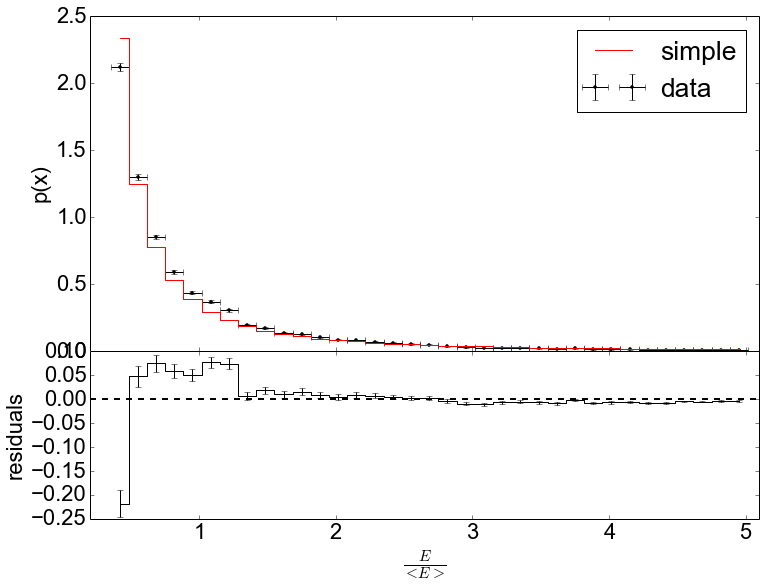


Results for the 'broken' model:
  Using scipy.optimize.minimze to minimize chi^2 yields:
    [MLEs], chisq/dof: [ 1.24204176  1.21116217  2.01119276  1.9525617   0.02091707] 12.5971818158

  Using scipy.optimize.curve_fit to obtain confidence intervals yields:
    N_0 = 1.242 +/- 0.028
    E_0 = 1.211 +/- 0.022
    Gamma_1 = 2.011 +/- 0.018
    Gamma_2 = 1.953 +/- 0.015
    E_bk = 0.021 +/- 0.013
    p-value for this fit = 0.00000


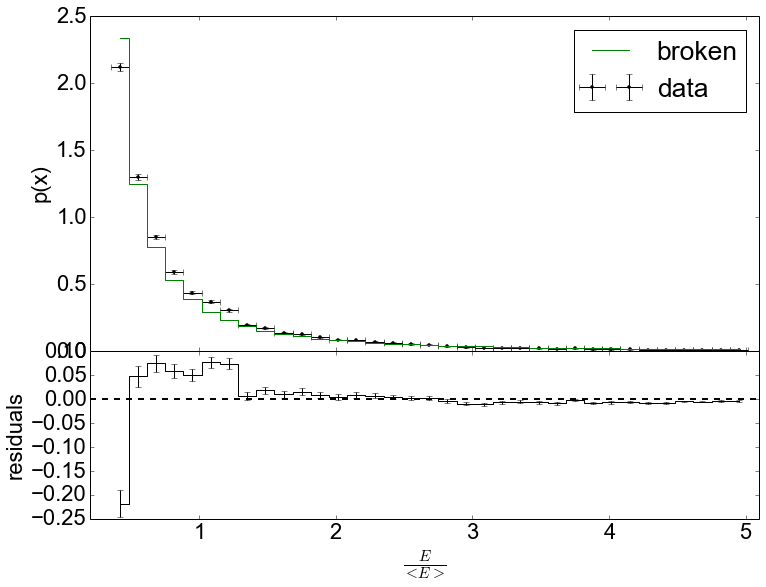


Results for the 'exp_cut' model:
  Using scipy.optimize.minimze to minimize chi^2 yields:
    [MLEs], chisq/dof: [ 1.33314775  2.16723852  1.45398134  2.34687333] 1.76126492426

  Using scipy.optimize.curve_fit to obtain confidence intervals yields:
    N_0 = 1.333 +/- 0.028
    E_0 = 2.167 +/- 0.022
    Gamma = 1.454 +/- 0.018
    E_cut = 2.347 +/- 0.015
    p-value for this fit = 0.00000


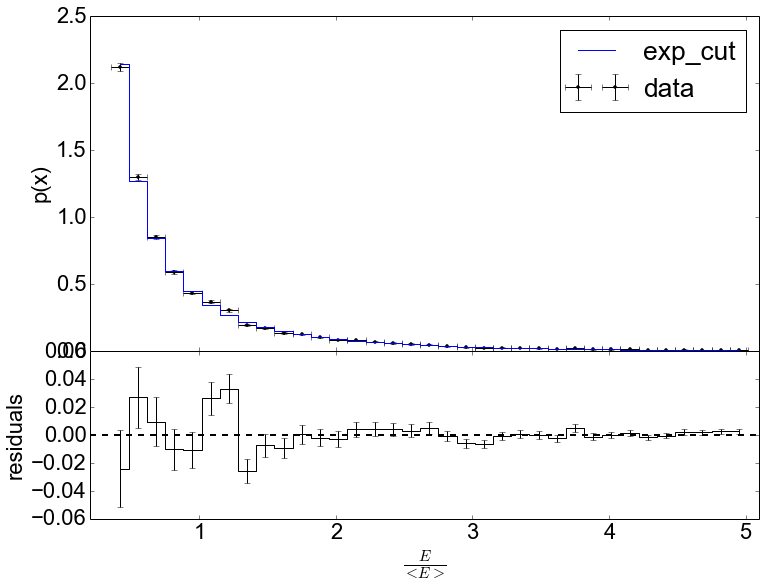

In [30]:
def simple_power_law_wrapper(dE):
    ''' Well, this could very well be Python Voodoo; it scares me as hell!
        This wrapper function allows passing a non-fit parameter (dE) to the fit function
        in the scipy.optimize.curve_fit (dE depends on the binning, it is the binsize).
        curve_fit, however, expects a function with the x values followed by only
        the fit parameters.
        
        I very much do not want to hardcode this inside the function because that
        will not end well should a different bin size be chosen. So we Voodoo this function *_*...
        
        https://stackoverflow.com/questions/10250461/passing-additional-arguments-using-scipy-optimize-curve-fit 
    '''
    def simple_power_law_new(x, parm0, parm1, parm2):
        N_0 = parm0
        E_0 = parm1
        Gamma = parm2
        E = x

        dN = N_0 * (E/E_0)**(-1. * Gamma) * dE
        return dN
    return simple_power_law_new


def broken_power_law_wrapper(dE):
    def broken_power_law_new(x, parm0, parm1, parm2, parm3, parm4):
        N_0 = parm0
        E_0 = parm1
        Gamma_1 = parm2
        Gamma_2 = parm3
        E_bk = parm4  # Is this a fit parameter, though?

        E_below = x[x <= E_bk]
        E_above = x[x > E_bk]              

        dN_below = N_0 * (E_below/E_0)**(-1. * Gamma_1) * dE  
        dN_above = N_0 * (E_bk/E_0)**(-1. * Gamma_1) * (E_above/E_bk)**(-1. * Gamma_2) * dE

        dN = numpy.concatenate([dN_below, dN_above])
        # dN = pandas.concat([dN_below, dN_above])
        return dN
    return broken_power_law_new


def exponentially_cut_off_power_law_wrapper(dE):
    def exponentially_cut_off_power_law_new(x, parm0, parm1, parm2, parm3):
        N_0 = parm0
        E_0 = parm1
        Gamma = parm2
        E_cut = parm3  # Is this a fit parameter, though?
        E = x

        dN = N_0 * (E/E_0)**(-1. * Gamma) * numpy.exp(-1. * E/E_cut) * dE
        return dN
    return exponentially_cut_off_power_law_new


def print_confidence_intervals_and_plot_residuals(model, result, print_cis=True, plot_residuals=True):
    dens, edges, err = create_and_plot_histogram(energies, plot=False)
    x = edges[:-1]
        
    binsize = edges[1] - edges[0]  # in GeV
     
    # Conifdence intervals
    functionpicker = {"simple": simple_power_law_wrapper ,
                      "broken": broken_power_law_wrapper,
                      "exp_cut": exponentially_cut_off_power_law_wrapper}
    function = functionpicker.get(model, None)
    
    if not function:
        print "Error: incorrect model name used"
        return
    
    ml_vals = result["x"]
    moddof = len(ml_vals)
    
    if print_cis:
        ml_func = result["fun"]
        dof = len(x) - moddof
        
        print "Results for the '{0}' model:".format(model)
        print "  Using scipy.optimize.minimze to minimize chi^2 yields:"
        print "    [MLEs], chisq/dof:", ml_vals, ml_func/dof
        print
    
    ml_vals, ml_covar = scipy.optimize.curve_fit(function(binsize), x, dens, p0=ml_vals, sigma=err,)
    ml_funcval = stat(ml_vals, x, dens, err, model, moddof)

    dof = len(x) - moddof
    errs = numpy.sqrt(numpy.diag(ml_covar))
    if print_cis:
        print "  Using scipy.optimize.curve_fit to obtain confidence intervals yields:"
        print "    N_0 = {0:.3f} +/- {1:.3f}".format(ml_vals[0], err[0])
        print "    E_0 = {0:.3f} +/- {1:.3f}".format(ml_vals[1], err[1])
        print "    {parm2_name} = {0:.3f} +/- {1:.3f}".format(ml_vals[2], err[2],
            parm2_name="Gamma" if model in ["simple", "exp_cut"] else "Gamma_1")
        if moddof > 3:
            print "    {parm3_name} = {0:.3f} +/- {1:.3f}".format(ml_vals[3], err[3],
                parm3_name="Gamma_2" if model=="broken" else "E_cut")
        if moddof > 4:
            print "    E_bk = {0:.3f} +/- {1:.3f}".format(ml_vals[4], err[4])

        ch = scipy.stats.chi2(dof)
        pval = 1.0 - ch.cdf(ml_funcval)
        print "    p-value for this fit = {0:.5f}".format(pval)
        
    # Residuals plot
    if plot_residuals:
        colourpicker = {"simple": "red" , "broken": "green", "exp_cut": "blue"}
        col = colourpicker.get(model, "black")
        functionpicker = {"simple": simple_power_law,
                          "broken": broken_power_law,
                          "exp_cut": exponentially_cut_off_power_law}
        function = functionpicker.get(model, None)

        if not function:
            print "Error: incorrect model name used"
            return

        fig = pyplot.subplots(2, 1, figsize=(12, 9))
        gs1 = matplotlib.gridspec.GridSpec(3, 3)
        gs1.update(hspace=0)
        ax1 = pyplot.subplot(gs1[:-1,:])
        ax2 = pyplot.subplot(gs1[-1,:])
        # ax1.tick_params(labelsize=15)
        # ax2.tick_params(labelsize=15)
        ax1.tick_params(labelbottom='off')

        ax1.set_xlim(0.2, 5.1)
        ax2.set_xlim(0.2, 5.1)

        ax1.set_ylabel("p(x)")
        ax2.set_ylabel("residuals")
        ax2.set_xlabel(r'$\frac{E}{<E>}$')
        ax1.errorbar(x + binsize/2., dens, xerr=binsize/2., yerr=err,
                     label="data", c="black", marker='o', linestyle='', markersize=3)
        ax1.plot(x + binsize/2., function(ml_vals, x, binsize),
                 label=model, c=col, drawstyle='steps-mid')

        ax2.axhline(y=0, linewidth=2, linestyle='dashed', c="black")

        ax2.errorbar(x + binsize/2., dens - function(ml_vals, x, binsize), yerr=err,
                     c="black", drawstyle="steps-mid")
        ax1.legend()
        pyplot.show()

    
    
if __name__ == '__main__':
    for model, result in fit_results.iteritems():
        print_confidence_intervals_and_plot_residuals(model, result)
        print 


### Question 3
- Search for emission lines, which may carry crucial information if they are associated with specific dark matter particle decays. You may assume a Gaussian profile to fit the emission line:
$$ dN = \frac{N_{\rm line}}{\sigma \sqrt{2 \pi}} \exp\left( \frac{(E - E_{\rm cent})^2)}{2 \sigma^2} \right) dE $$ where $E_{\rm cent}$ is the line centroid energy, $\sigma$ is the line width and $N_{\rm line}$ is the expected total number of photons contained in the line. The width of any lines is set by the instrumental resolution (which is a function of energy) and is given by:

$$ \sigma = 2.0 \sqrt{\frac{E_{\rm cent}}{200 \, \rm{ GeV}}} \, \rm{ Gev} $$

### Answer 3

### Question 4
- [Professor Denzil Dexter](http://www.teachertube.com/video/professor-denzil-dexter-81357) of the University of Southern California has proposed a dark matter candidate particle, the _Dextron_, which should result in a Gaussian emission line of width 1 GeV at an energy of 45.3 GeV. In case this line isn't detected, use your data to set a $3\sigma$ upper limit on the predicted number of photons that this line could contain.

Note that in all cases you should estimate $p$-values and significances for your hypothesis tests. You should explain your reasoning and choices and discuss how you interpret your results as you go along. Make sure that you make sensible decisions about how your report your results, e.g. about the number of significant figures used. You should also, in as much as possible, determine confidence intervals on the best-fitting model parameters (for continuum and emission line models). If errors appear to be correlated between parameters, you should also attempt to plot 2-dimensional confidence contours.Overall, we are looking for evidence that you understand and can apply the material in the course on model-fitting, parameter estimation and hypothesis testing, so you will find the information in the lectures in weeks 4, 5 and 6 to be very useful, as well as the case studies lecture from week 6.

### Answer 4